In [1]:
%cd ..

/home/jairo/Documentos/GitHub/parallel-kink-scattering


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from modules.numeric import *

In [3]:
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import ScalarMappable

In [6]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='computer modern roman')
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amssymb,bm,physics,lmodern}')

In [7]:
phi4 = Phi4()

def chi(H, mu, nu):
    return np.arctanh((mu*H)**nu)

def varphi(x, mu, nu):
    return -mu*np.tanh(x)**nu

def phi_dirichlet(x, H):
    assert H > -1
    mu = 1
    nu = 1 if H < 1 else -1
    return np.r_[[1]*len(x)] if H == 1 else varphi(x - chi(H, mu, nu), mu, nu)

def y0(x, x0, v, H):
    return np.stack((
        phi_dirichlet(x, H) + phi4.kink(x - x0, 0, v) - 1,
        phi4.kink_dt(x - x0, 0, v)
    ))

In [8]:
values = np.r_[-0.999, -0.5, 0, 0.5, 1, 1.5, 2, 3]
cmap = plt.get_cmap('Spectral_r', len(values))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1.8]})

cs = {1:cmap(0), -1:cmap(len(values)-2)}
ls = {1:'-', -1:'--'}

x = np.linspace(-3, 3, 250)
for mu in (1, -1):
    for nu in (1, -1):
        ax1.plot([], [], c=cs[mu], ls=ls[nu], label=r'$\mu, \nu = {%s}, {%s}$'%(mu, nu))
        for i, xi in enumerate((x[x < 0], x[x > 0])):
            ax1.plot(xi, varphi(xi, mu, nu), c=cs[mu], ls=ls[nu], lw=2)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(-3, 3)

ax1.set_xlabel(r'$x$', fontsize=16)
ax1.set_ylabel(r'$\varphi\left(x;\chi=0\right)$', fontsize=16)
        
ax1.grid(alpha=0.6, ls='--')
ax1.legend(framealpha=1, bbox_to_anchor=(0.7, 0.75))
ax1.set_title('(a)')

ax1.axvline(0, ls='-', lw=1, c='k')
ax1.set_aspect('equal')

ax1.fill_betweenx((-3, 3), 0, 5, alpha=0.1, color='k')

x = np.linspace(-8, 0, 500)

for i, H in enumerate(values):
    ax2.plot(x, phi_dirichlet(x, H), c=cmap(i), lw=2, zorder=len(values)-i)

ax2.set_ylim(-2, 3)
ax2.set_xlim(x.min(), x.max())

ax2.set_yticks((-2, -1, 0, 1, 2, 3))

ax2.set_xlabel(r'$x$', fontsize=16)
ax2.set_ylabel(r'$\varphi(x; \mu=1)$', fontsize=16)
ax2.set_xticks((0, -2, -4, -6, -8))
ax2.grid(alpha=0.6, ls='--', zorder=-1)
ax2.set_title('(b)')

dvs = np.r_[-1.5, values]
cbar = fig.colorbar(ScalarMappable(norm=BoundaryNorm(dvs, ncolors=len(dvs)), cmap=ListedColormap([cmap(i) for i in range(len(dvs))])), ax=ax2)
cbar.ax.set_yticks((dvs[:-1] + dvs[1:])/2, (r'$\sim$ -1', *values[1:]))
cbar.minorticks_off()
cbar.ax.set_title(r'$H$')

fig.tight_layout()
fig.savefig('reports/dirichlet/solutions.pdf', bbox_inches='tight', dpi=2000, pad_inches=0)
plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

Error in callback <function _draw_all_if_interactive at 0x79d9c7aec940> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1200x400 with 3 Axes>

In [7]:
L = 100
N = 1024
DX = L/(N - 1)
DT = 4e-2
X0 = -10

In [8]:
def glue(H):
    def wrapped(t, Y):
        Y[0, -1] = H
    return wrapped

booster = Booster(
    x_lattice= (-L, 0, N), 
    dt= DT, 
    order= 4,
    y0= y0,
    pot_diff= phi4.diff,
    boundaries= ('reflective', 'dirichlet'),
    integrator='sy6',
)

def plot_boundary_scatter(v, H, t_final=100, ax=None):
    if ax == None: ax = plt.gca()
    booster.rb.param = H
    booster.event = glue(H)
    lat, Y = booster.run(t_final, v=v, x0=X0, H=H)
    y, dydt = Y[:, 0], Y[:, 1]
    ax.imshow(y, cmap='Spectral_r', vmin=-1, vmax=1, extent=(lat.x.min(), lat.x.max(), lat.t.min(), lat.t.max()), aspect='auto', origin='lower')
    ax.set_xlim(-30, 0)
    return lat, y, dydt

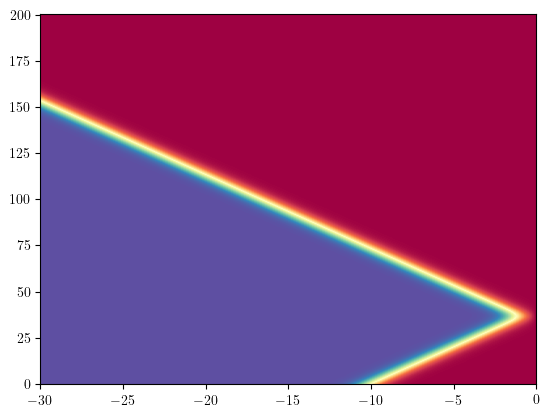

In [9]:
lat, y, dydt = plot_boundary_scatter(0.25, 1, t_final=200)
plt.show()

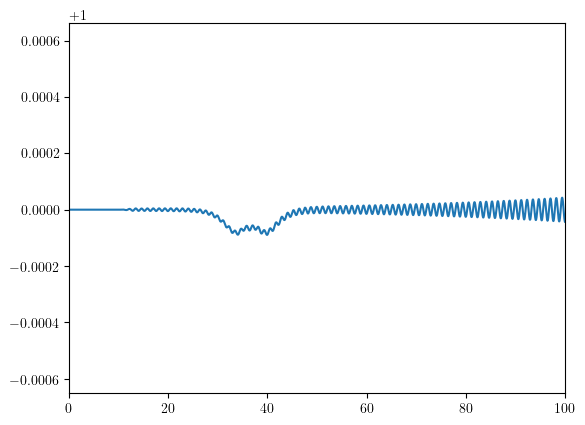

In [10]:
plt.plot(lat.t, y[:, -1])
# plt.plot(lat.t, dydt[:, -1])
plt.xlim(0, 100)
plt.show()

In [4]:
savedir = Path('data/session-dirichlet')
files = tuple(savedir.glob('*'))
len(files)

4166

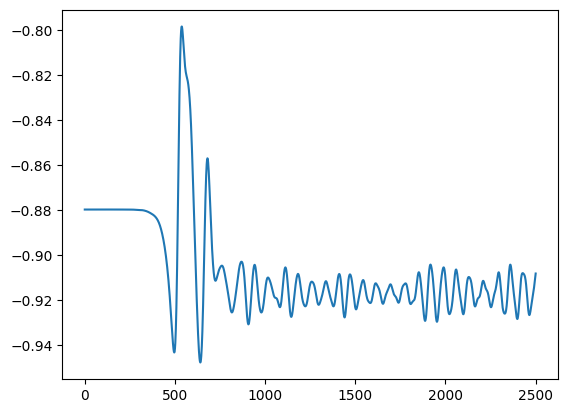

In [35]:
n = np.random.randint(0, len(files))
with open(files[n], 'rb') as file:
    Y = np.load(file)
# plt.imshow(Y, aspect='auto', cmap='Spectral_r', vmin=-1, vmax=1)
plt.plot(Y[:, -2])

In [28]:
len(tuple(savedir.glob('*(0.5)')))

749

In [33]:
scan = []
for file in savedir.glob('(-0.9)*'):
    with open(files[n], 'rb') as file:
        Y = np.load(file)
        scan.append(Y[:, -5])

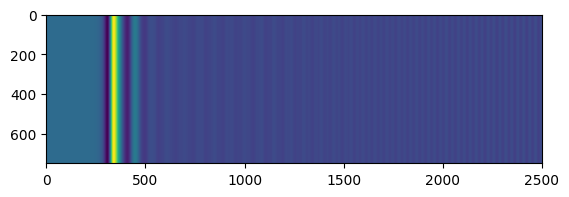

In [34]:
plt.imshow(scan)